# Projeto - Análise e Predição de Rotatividade de Clientes em Academia

## Propósito e planejamento da análise
Trabalho realizado para a rede de academias Model Fitness, com o propósito de analisar dados de clientes para prever a probabilidade de rotatividade e apoiar estratégias de retenção. 

**Objetivo:** Analisar os dados dos clientes para prever a probabilidade de rotatividade, identificar perfis típicos de usuários e compreender os principais fatores que influenciam esse comportamento. Com base nisso, propor recomendações que apoiem decisões estratégicas e fortaleçam a fidelização dos clientes.

### Plano de análise
A análise foi realizada com base em dados digitalizados disponíveis no arquivo `gym_churn_us.csv`. Este arquivo contém  dados sobre rotatividade em um determinado mês e informações sobre o mês anterior.

As etapas de análise foram:


[1. Inicialização e preparação dos dados](#etapa1)

Carregamento das bibliotecas; leitura do(s) arquivo(s); verificação e tratamento de tipos de dados, valores ausentes e duplicados; e, se necessário: correção dos tipos de dados e ajustes no DataFrame para facilitar a análise (renomeações, filtros e criação de colunas auxiliares) 


[2. Análise exploratória de dados (AED)](#etapa2)

   * [2.1. Média e desvio padrão das características](#etapa2-1)

   * [2.2. Média dos valores médios das características em dois grupos (segundo a rotatividade)](#etapa2-2)
    
   * [2.3. Matriz de correlação](#etapa2-3)
    


[3. Construção de modelo para predizer a rotatividade de clientes](#etapa3)

   * [3.1. Divisão dos dados de treinamento e validação](#etapa3-1)

   * [3.2. Treinamento do modelo](#etapa3-2)
   * [3.2.1. Regressão Logística](#etapa3-2-1)
   * [3.2.2. Floresta aleatória](#etapa3-2-2)
        
   * [3.3. Comparação dos modelos](#etapa3-5) 
    

[4. Criação de agrupamentos de clientes](#etapa4)

   * [4.1. Padronização dos dados](#etapa4-1)
    
   * [4.2. Matriz das distâncias e dendograma](#etapa4-2)
        
   * [4.3. Treinando o modelo KMeans com n=5](#etapa4-3)
    
   * [4.4. Distribuição de características para os agrupamentos](#etapa4-4)

   * [4.5. Taxa de rotatividade](#etapa4-5)

[5. Conclusões e recomendações básicas](#etapa5)


### Descrição de dados
* `Churn` — a rotatividade do mês em questão
* Campos de dados atuais:
    * Dados do mês anterior
        * `gender`
        * `Near_Location` — se o cliente morar ou trabalhar na vizinhança onde a academia está localizada
        * `Partner` — se o usuário for um funcionário de uma companhia parceira (a academia tem empresas parceiras cujos funcionários conseguem descontos; nesses casos, a academia armazena informações sobre clientes de são funcionários)
        * `Promo_friends` — se o cliente originalmente se inscreveu através de uma oferta "traga um amigo" (eles normalmente usam o código de promoção do amigo quando pagam pela primeira filiação)
        * `Phone` — se o usuário fornece o seu número de telefone
        * `age` (idade)
        * `Lifetime` — o tempo (em meses) desde a primeira vez que o cliente veio à academia
    * Dados do log de frequência e compras e dados sobre status de filiação atual
        * `Contract_period` — 1 mês, 3 meses, 6 meses, ou um ano
        * `Month_to_end_contract` — os meses remanescentes até que o contrato expira
        * `Group_visits` — se o cliente participa de sessões em grupo
        * `Avg_class_frequency_total` — frequência média de idas por semana por toda a vida do cliente
        * `Avg_class_frequency_current_month` — frequência média de visitas por semana durante o mês corrente
        * `Avg_additional_charges_total` — a quantidade total de dinheiro gasto em outros serviços da academia: café, artigos esportivos, cosméticos, massagem, etc.

## 1. Inicialização e preparação dos dados <a id="etapa1"></a>

In [1]:
# importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# leitura do df
gym = pd.read_csv('datasets/gym_churn_us.csv')

In [4]:
# impressão das informações do df
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
# amostra de dados do df
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
# verifica se há linhas completamente duplicadas
gym.duplicated().sum()

np.int64(0)

Observações sobre o df:
* O df não possui dados ausentes aparentes
* O df não possui linhas completamente duplicadas
* O título das colunas não está padronizado pela estratégia snake_case, o que deve ser padronizado
* As colunas de índice 0, 1, 2, 3, 4, 5 e 13 apresentam valores binários (0 ou 1)
* Os dados da coluna `Month_to_end_contract` devem ser convertidos para tipo int. Para isso, é necessário verificar valores únicos da coluna para identificar a possibilidade de conversão ou necessidade de ajustes.

In [7]:
# padroniza o título das colunas: remove espaços, deixa lowercase e snake_case
new_col_names = [] # lista de novos nomes para as colunas

for old_name in gym.columns: 
    name_stripped = old_name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    new_col_names.append(name_no_spaces)

# substitui os nomes antigos pelos novos
gym.columns = new_col_names

In [8]:
# verifica os valores únicos da coluna 
sorted(gym['Month_to_end_contract'].unique())

KeyError: 'month_to_end_contract'

In [ ]:
# converte a coluna month_to_end_contract para tipo int
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype(int)

In [ ]:
# verifica as informações do df após as alterações
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

## 2. Análise exploratória de dados (AED) <a id="etapa2"></a>

### 2.1. Média e desvio padrão das características <a id='etapa2-1'></a>

In [ ]:
# descrição estatística do df para visualizar a média e desvio padrão das características
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Observações das estatísticas:**

* **Variáveis binárias**

    * `gender` - cerca de 51% dos clientes são do grupo 1 (desvio padrão máximo)
    * `near_location` - 85% dos clientes moram perto da academia (desvio padrão baixo - dispersão baixa)
    * `partner` - média próxima a 49% e desvio padrão \~0,50 (alta variabilidade - divisão equilibrada entre 0 e 1)
    * `promo_friends` - cerca de 31% dos clientes chegaram via promoção de amigos
    * `phone` - aproximadamente 90% forneceram telefone (desvio padrão baixo - característica homogênea)
    * `group_visits` - 41% participam de visitas em grupo (desvio padrão alto - divisão equilibrada entre 0 e 1)
    * `churn` - cerca de 26,5% dos clientes abandonam a academia (std aprox. 0,44), rotatividade significativa


* **Variáveis contínuas**

    * `age` - média de 29 anos (std aprox. 3,3), público jovem e relativamente homogêneo
    * `avg_additional_charges_total` - média de 147 (std aprox. 96), alta variação nos gastos adicionais dos clientes
    * `month_to_end_contract` - média de 4,3 meses (std aprox. 4,2), contratos distribuídos entre períodos curtos e longos
    * `lifetime` - média de 3,7 meses (std aprox. 3,7), sugerindo retenção inicial frágil
    * `avg_class_frequency_total` - frequência média de 1,9 vezes/semana (std aprox. 1), variação entre clientes regulares e menos assíduos
    * `avg_class_frequency_current_month` - média de 1,8 vezes/semana (std aprox. 1,05), próxima da média geral, mas com maior dispersão

### 2.2. Média dos valores médios das características em dois grupos (segundo a rotatividade) <a id="etapa2-2"></a>

In [ ]:
# compara clientes que ficaram e os que saíram
gym.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


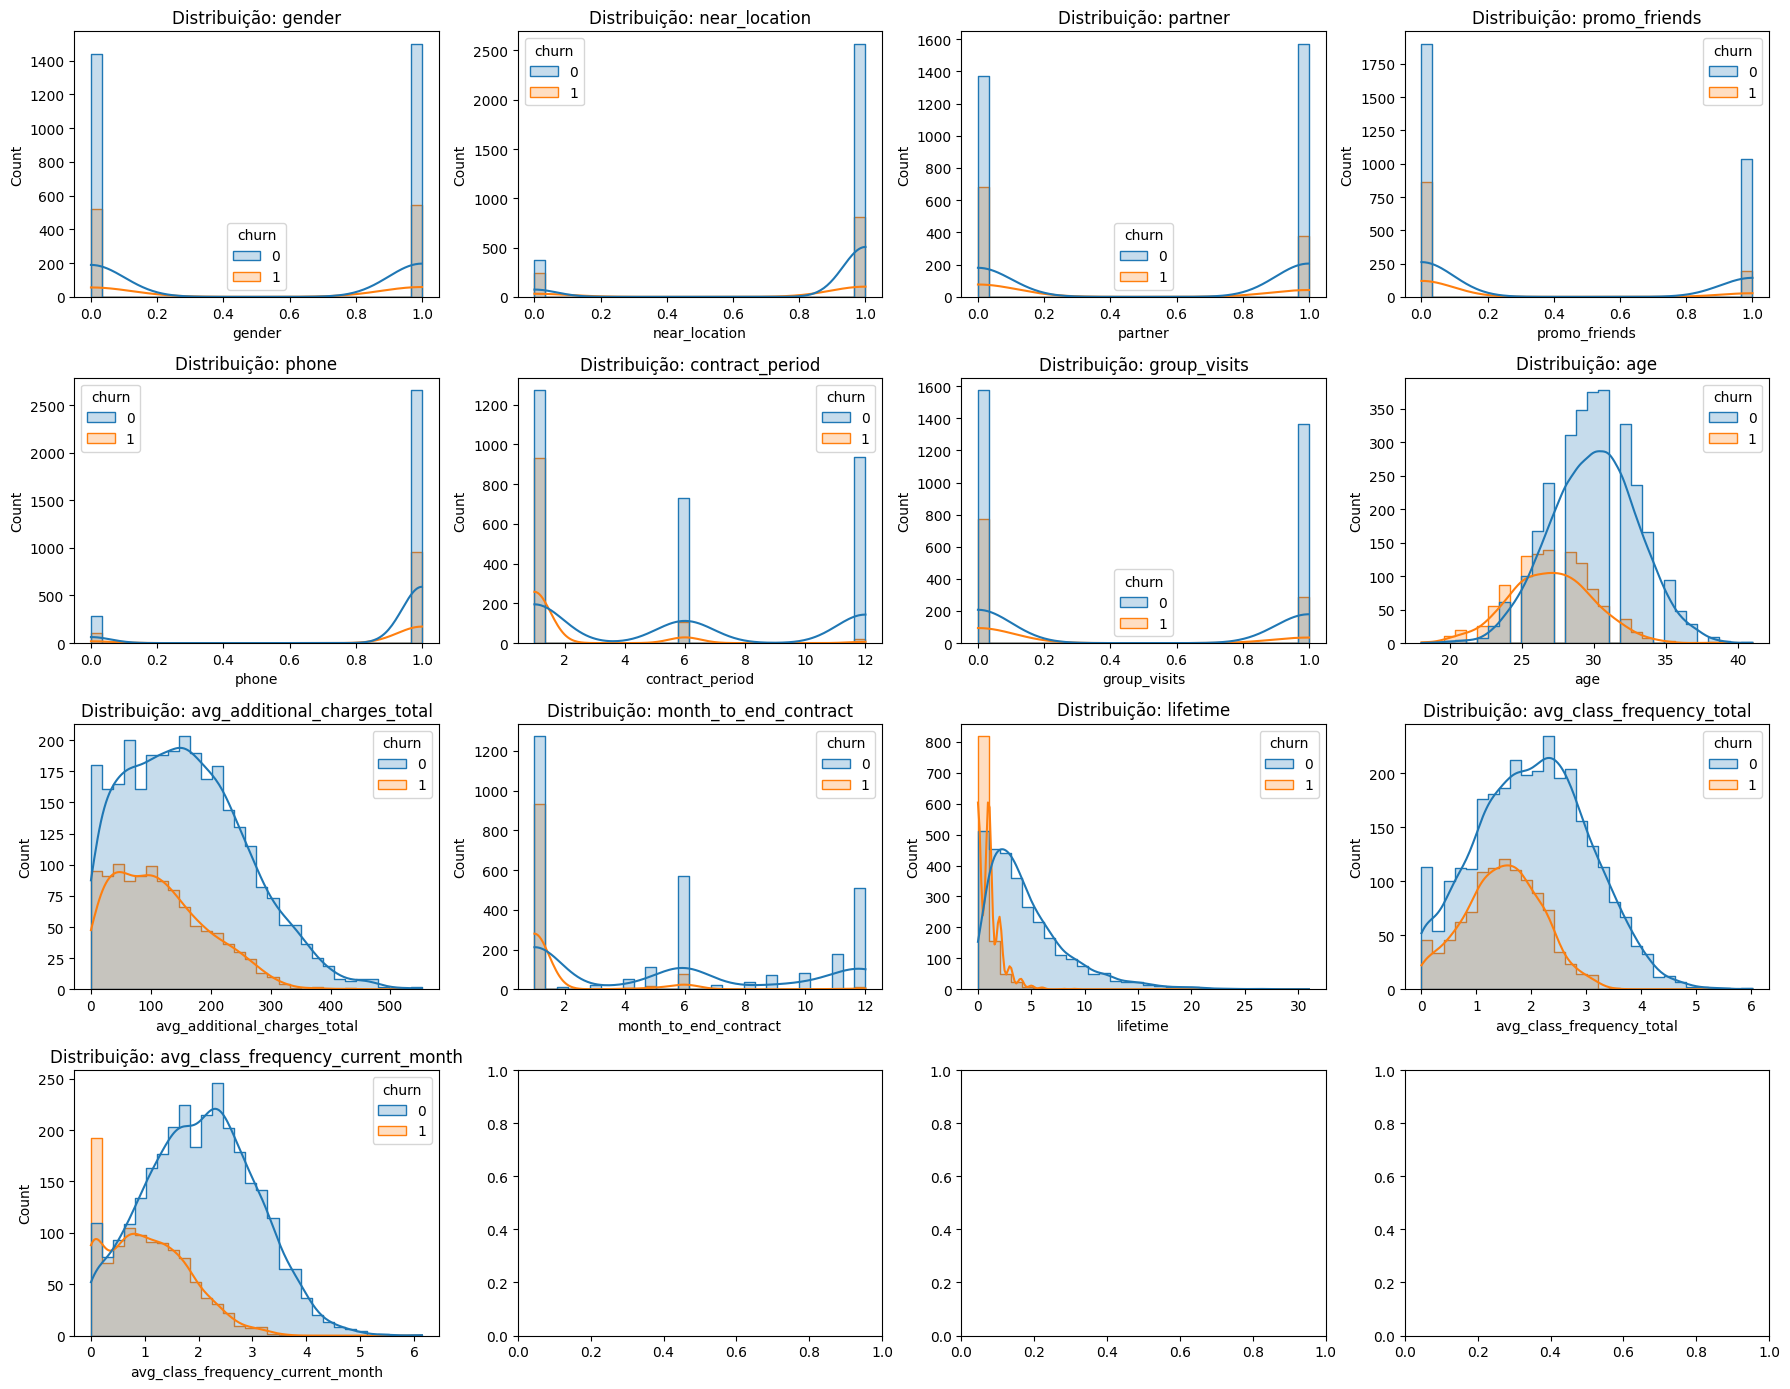

In [ ]:

columns_to_plot = gym.drop('churn', axis=1).columns

# cria grade (4 linhas x 4 colunas)
fig, axes = plt.subplots(4, 4, figsize=(18, 14))

# transforma em vetor p/ indexar facilmente
axes = axes.flatten()

# Loop: usa axes[i] dentro do loop
for i, col in enumerate(columns_to_plot):
    sns.histplot(
        data=gym,
        x=col,
        hue='churn',
        kde=True,
        bins=30,
        element='step',
        ax=axes[i]         
    )
    axes[i].set_title(f'Distribuição: {col}')


plt.tight_layout()
plt.show()
plt.close()

**Observações**

| Característica                           | Padrão nos que ficaram (`churn = 0`)                         | Padrão nos que saíram (`churn = 1`)                  |
| ----------------------------------- | ------------------------------------------------------------ | ---------------------------------------------------- |
| `gender`                            | Distribuição equilibrada                                     | Distribuição equilibrada (sem diferenças relevantes) |
| `near_location`                     | Maioria mora perto (\~87%)                                   | Proporção menor (\~77%)                              |
| `partner`                           | Maior presença de funcionários de empresas parceiras (\~53%) | Menor presença (\~36%)                               |
| `promo_friends`                     | Mais clientes vieram por indicação de amigos (\~35%)         | Menos clientes vieram por indicação (\~18%)          |
| `phone`                             | Quase todos forneceram telefone (\~90%)                      | Quase todos forneceram telefone (\~90%)              |
| `contract_period`                   | Contratos mais longos (média \~5,7 meses)                    | Contratos curtos (média \~1,7 meses)                 |
| `group_visits`                      | Maior adesão (\~46%)                                         | Menor adesão (\~27%)                                 |
| `age`                               | Mais velhos (média \~30 anos)                                | Mais jovens (média \~27 anos)                        |
| `avg_additional_charges_total`      | Gastos maiores em extras (\~158)                             | Gastos menores (\~115)                               |
| `month_to_end_contract`             | Mais meses restantes (\~5,3)                                 | Poucos meses restantes (\~1,7)                       |
| `lifetime`                          | Maior tempo de relacionamento (\~4,7 meses)                  | Baixo tempo de casa (\~1 mês)                        |
| `avg_class_frequency_total`         | Frequência média de \~2x por semana                          | Frequência média de \~1,5x por semana                |
| `avg_class_frequency_current_month` | Frequência mantida alta (\~2x por semana)                    | Frequência baixa (\~1x por semana)                   |



* Clientes que permanecem (`churn = 0`) tendem a ser mais velhos, engajados e com contratos longos, mantendo frequência regular de treinos e maior gasto em serviços adicionais.
* Fatores como morar perto, ser funcionário de empresas parceiras e participar de grupos estão claramente associados à retenção.
* Clientes que saem (`churn = 1`) são mais jovens, com contratos curtos, menor tempo de relacionamento, baixa frequência e menor gasto em extras, refletindo baixo engajamento.
* Variáveis como `gender` e `phone` não apresentam diferenças significativas, indicando menor impacto direto na rotatividade.

### 2.3. Matriz de correlação <a id="etapa2-3"></a>

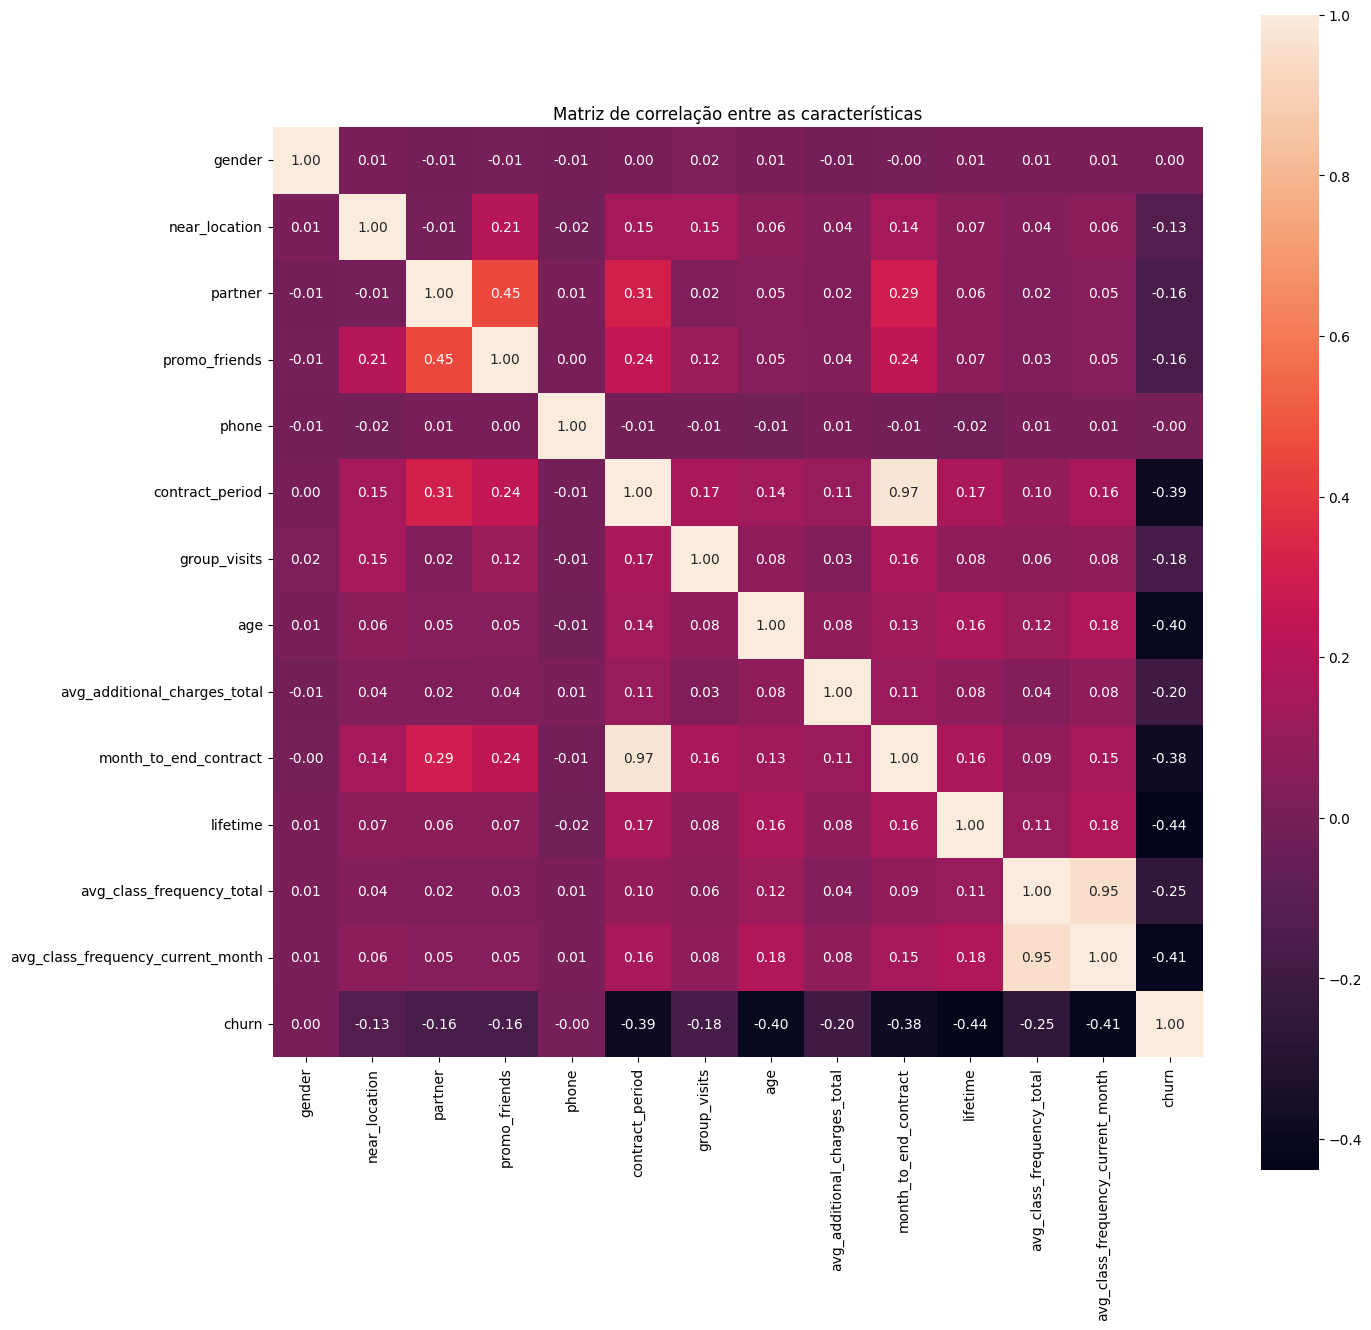

In [ ]:
# matriz de correlação
corr_m = gym.corr()

# faça um mapa de calor
plt.figure(figsize=(15, 15))
sns.heatmap(corr_m, square=True, annot=True, fmt=".2f")
plt.title('Matriz de correlação entre as características')
plt.show()
plt.close()

Variáveis mais correlacionadas com churn são as com valores mais negativos:
  * `lifetime` (≈ -0.44) → quanto mais tempo de casa, menor a chance de sair.
  * `avg_class_frequency_current_month` (≈ -0.41) → quem treinou mais no último mês tende a permanecer.
  * `age` (≈ -0.40) → clientes mais velhos têm menor chance de churn.
  * `contract_period` (≈ -0.39) → contratos mais longos estão associados a maior retenção.
  * `month_to_end_contract` (≈ -0.38) → mais meses restantes reduzem a chance de churn.
  * `avg_class_frequency_total` (≈ -0.25) → frequência média histórica também reduz churn, mas menos que a do último mês.
  * `avg_additional_charges_total` (≈ -0.20) → quem gasta mais em extras tende a permanecer.

**Em resumo:** tempo, engajamento e idade são os fatores mais protetores contra a rotatividade.

## 3. Construção de modelo para predizer a rotatividade de clientes <a id="etapa3"></a>


Modelo de classificação binária para clientes onde a variável objetivo é a saída de usuários do próximo mês.

### 3.1. Divisão dos dados de treinamento e validação <a id="etapa3-1"></a>

In [ ]:
# divide os dados em características (a matriz X) e a variável objetivo (y)
X = gym.drop('churn', axis = 1)
y = gym['churn']

In [ ]:
# divide os dados sobre treinos e testes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# treine StandardScaler no conjunto de trem
scaler = StandardScaler()
scaler.fit(X_train)

# transforme os conjuntos de trem e teste
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### 3.2. Treinamento do modelo <a id="etapa3-2"></a>

#### 3.2.1. Regressão Logística <a id="etapa3-2-1"></a>

In [ ]:
# define o algoritmo para o modelo de regressão logística
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# treina o modelo
lr_model.fit(X_train, y_train)

# usa o modelo treinado para fazer previsões
predictions = lr_model.predict(X_test) # previsão binária
probabilities = lr_model.predict_proba(X_test)[:,1]

In [ ]:
# avalia o modelo
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precisão: {:.2f}'.format(precision_score(y_test, predictions)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, predictions)))

Acurácia: 0.92
Precisão: 0.87
Sensibilidade: 0.78


#### 3.2.2. Floresta aleatória <a id="etapa3-2-2"></a>

In [ ]:
# define o algoritmo para o novo modelo de floresta aleatória
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

# treine o modelo de floresta aleatória
rf_model.fit(X_train_st, y_train)
# use o modelo treinado para fazer previsões
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
    
# avalia o modelo
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precisão: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, rf_predictions)))


Acurácia: 0.91
Precisão: 0.85
Sensibilidade: 0.78


### 3.3. Comparação dos modelos <a id="etapa3-3"></a>

Os dois modelos têm desempenho muito próximo, com sensibilidade (recall) idêntico (0.78). No entanto, a regressão logística se destaca por ter maior precisão (0.87 vs. 0.85) e ligeiramente melhor acurácia (0.92 vs. 0.91).

## 4. Criação de agrupamentos de clientes <a id="etapa4"></a>

### 4.1. Padronização dos dados <a id="etapa4-1"></a>

In [ ]:
# divide os dados em características (a matriz X) e a variável objetivo (y)
X_clustering = gym.drop('churn', axis = 1)
y = gym['churn']

# padroniza os dados
sc = StandardScaler()
X_sc = sc.fit_transform(X_clustering)

### 4.2. Matriz das distâncias e dendograma <a id="etapa4-2"></a>

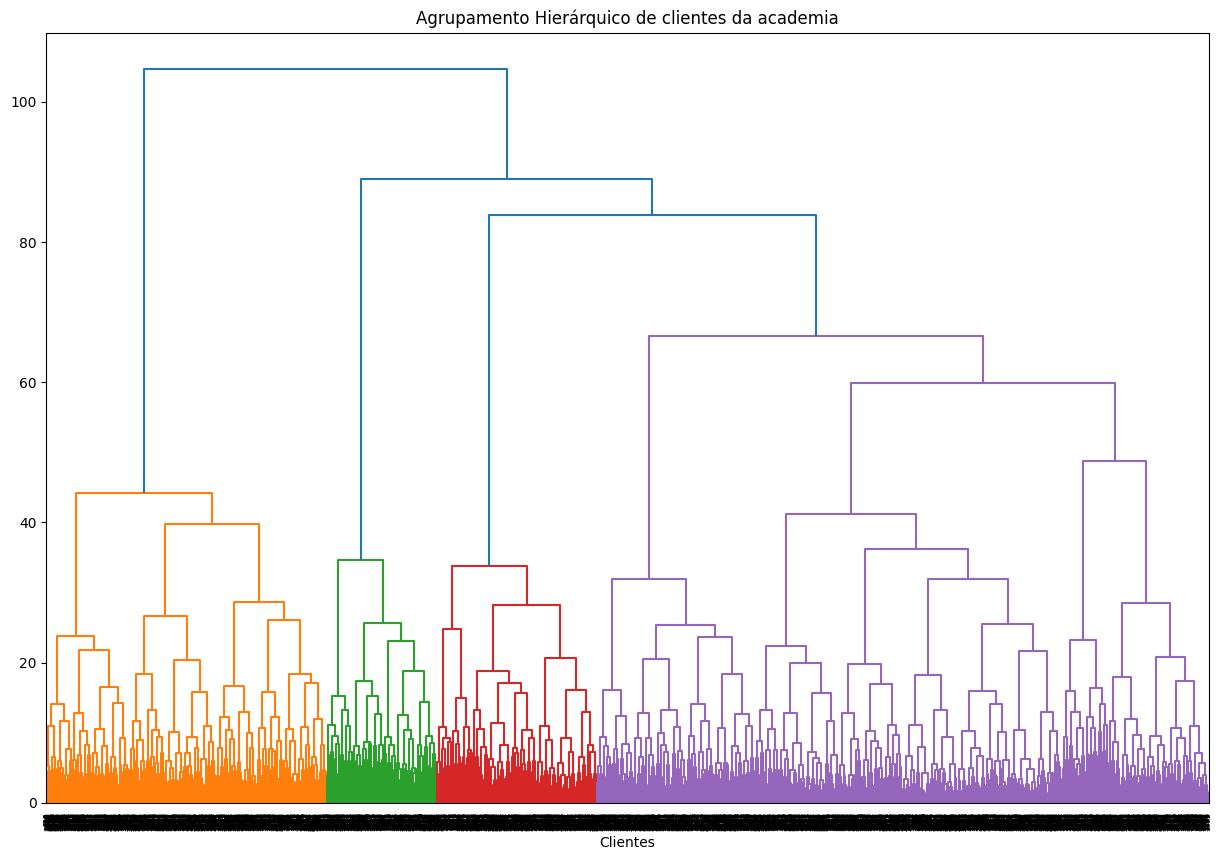

In [ ]:
# calcula a matriz de distâncias usando o método de Ward
linked = linkage(X_sc, method='ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupamento Hierárquico de clientes da academia')
plt.xlabel('Clientes')
plt.ylabel('Distância Euclidiana')
plt.show()
plt.close()

### 4.3. Treinando o modelo KMeans com n=5 <a id="etapa4-3"></a>

In [ ]:
# define o modelo k_means com 5 agrupamentos
km = KMeans(n_clusters=5)

# prevê os agrupamentos para observações (o algoritmo atribui a eles um número de 0 a 4)
labels = km.fit_predict(X_sc)

# armazene rótulos de agrupamento no campo do nosso conjunto de dados
gym['cluster_km'] = labels

# obtenha as estatísticas dos valores médios de características por agrupamento
gym.groupby(['cluster_km']).mean()


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.495430,0.000000,0.466179,0.076782,0.915905,2.243144,0.213894,28.486289,133.939051,2.100548,2.819013,1.659922,1.470159,0.447898
1,0.586563,0.972868,0.375969,0.264858,0.904393,2.900517,0.479328,30.434109,164.626921,2.665375,5.276486,2.987164,2.999419,0.031008
2,0.506757,0.950772,0.768340,0.553089,0.902510,11.287645,0.559846,29.964286,164.582993,10.349421,4.776062,1.994149,1.987408,0.022201
3,0.000000,1.000000,0.369718,0.257042,0.899061,2.120892,0.342723,28.443662,133.318560,2.010563,2.690141,1.378903,1.190067,0.444836
4,1.000000,1.000000,0.366625,0.246523,0.900126,2.214918,0.365360,28.219975,130.206851,2.078382,2.570164,1.334100,1.099353,0.493047


**Observações:**
* Clusters 1 e 2: clientes mais engajados, com contratos mais longos, frequência alta, forte vínculo social (parcerias e promoções) e churn muito baixo (~2–3%).
* Clusters 0, 3 e 4: clientes de contratos curtos, baixa frequência e churn elevado (~45–50%).
* O algoritmo ainda separou dois grupos quase exclusivamente por gênero (clusters 3 e 4), ambos com baixa retenção.

### 4.4. Distribuição de características para os agrupamentos <a id="etapa4-4"></a>

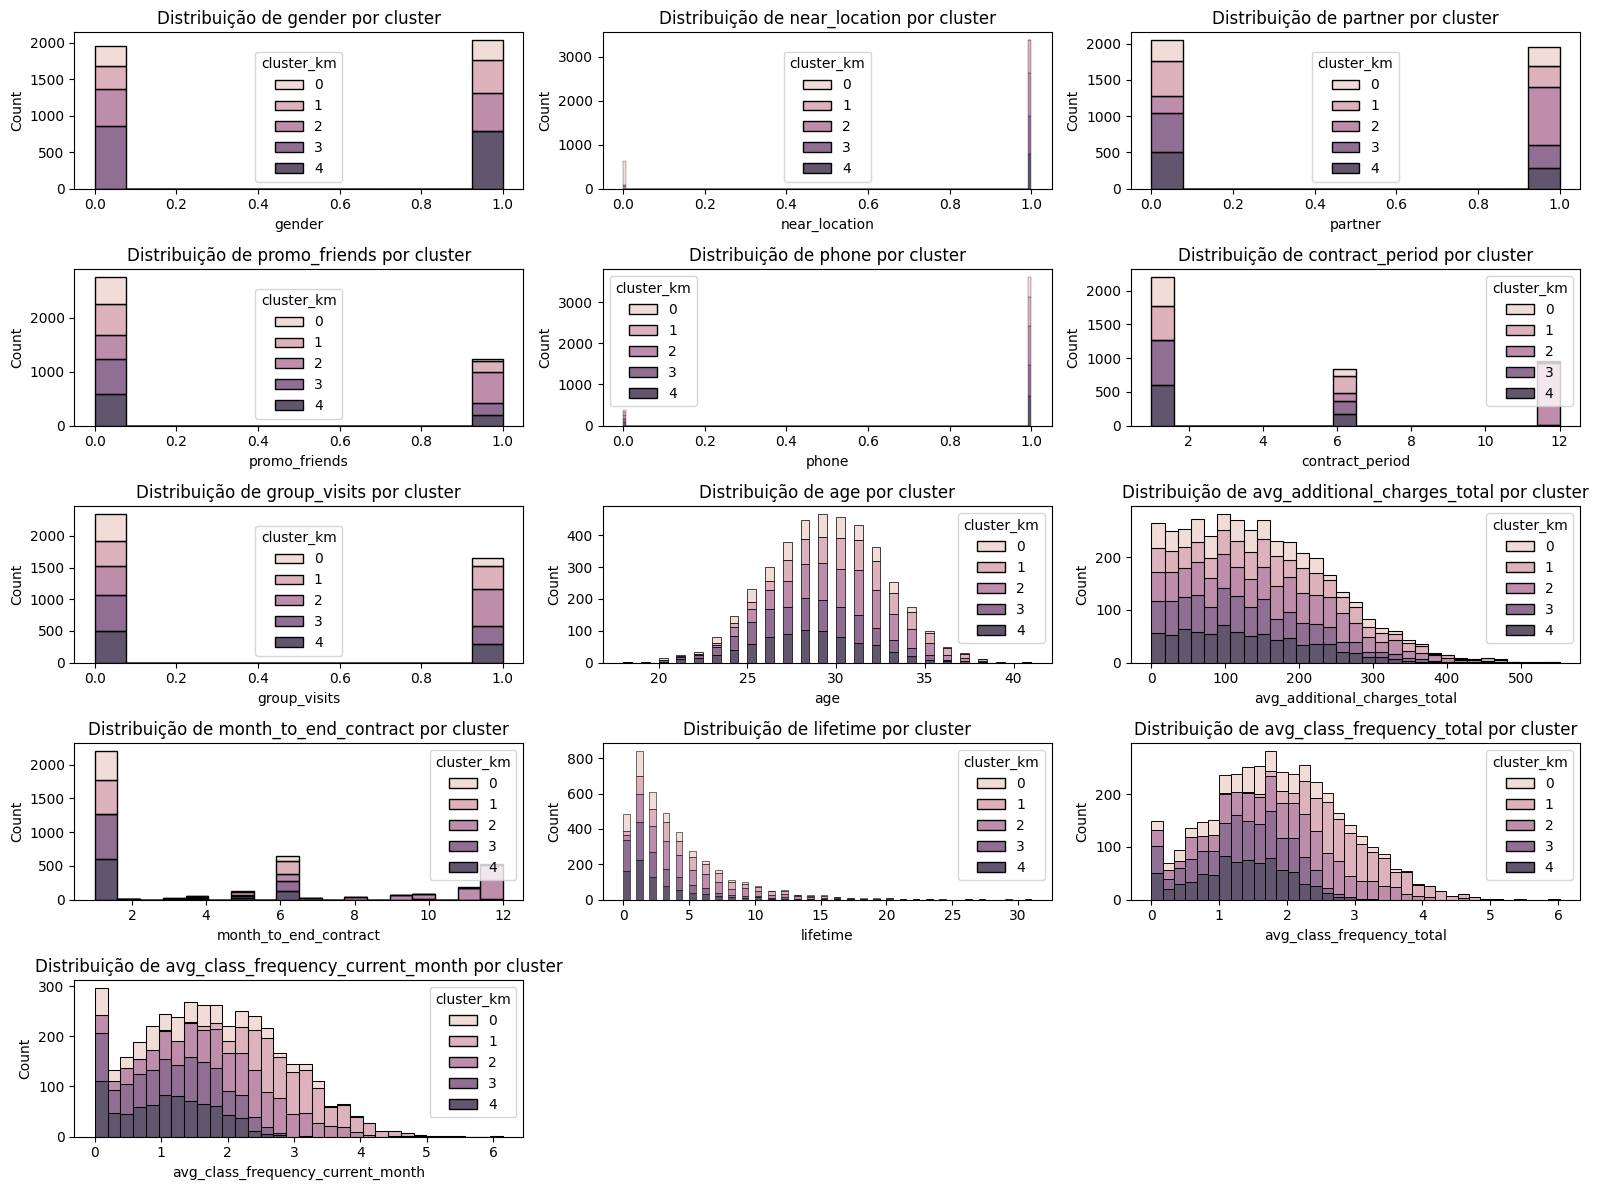

In [ ]:
# listando as características (colunas) para as quais queremos fazer a distribuição
features = gym.columns[:-2]  # Excluindo 'Churn' e 'Cluster' para focar nas características

# criando gráficos de distribuição para cada característica
plt.figure(figsize=(16, 12))

# iterando pelas características e criando um gráfico para cada uma
for i, feature in enumerate(features):
    plt.subplot(5, 3, i + 1)  # Subplot com 5 linhas e 3 colunas
    sns.histplot(data=gym, x=feature, hue='cluster_km', multiple='stack')
    plt.title(f'Distribuição de {feature} por cluster')

# ajustando o layout
plt.tight_layout()
plt.show()

**Observações:**

As distribuições confirmam que clientes mais engajados (clusters 1 e 2), com contratos longos, maior gasto em extras e localização próxima, têm baixíssimo churn. Já clusters 0, 3 e 4 concentram perfis de risco, com contratos curtos, baixa frequência e churn elevado — sendo que 3 e 4 ainda ficaram segmentados quase exclusivamente por gênero.

### 4.5. Taxa de rotatividade <a id="etapa4-5"></a>
* Calcule a taxa de rotatividade para cada agrupamento (use o método groupby()). Eles diferem em termos de taxa de rotatividade? Quais agrupamentos são propensos a sair, e quais são leais?

In [ ]:
# calcula a taxa de rotatividade para cada cluster
gym.groupby('cluster_km')['churn'].mean().sort_index()


cluster_km
0    0.447898
1    0.031008
2    0.022201
3    0.444836
4    0.493047
Name: churn, dtype: float64

**Observações** 
* Clusters 1 e 2 → representam os clientes mais valiosos, com churn muito baixo (<5%). Estratégias de retenção funcionam bem aqui.

* Clusters 0, 3 e 4 → concentram os clientes de risco, com churn altíssimo (~45–50%). Esses grupos precisam de ações urgentes (incentivos, contratos mais longos, programas de engajamento).

* A segmentação mostra um contraste claro: ou o cliente é muito fiel ou está em alto risco de saída, quase sem “meio-termo”.

* O cluster 4, além de ser 100% concentrado em um gênero, é o mais problemático → exige análise específica.

## 5. Conclusões e recomendações básicas <a id="etapa5"></a>

A análise mostrou que a retenção depende de engajamento, contratos longos e vínculos sociais, enquanto clientes com baixa frequência, menor tempo de relacionamento e contratos curtos apresentam maior risco de saída. Para reduzir a rotatividade, recomenda-se: incentivar planos de longo prazo com benefícios extras, estimular a frequência por meio de desafios e programas de recompensa, e fortalecer vínculos sociais com aulas coletivas e promoções “traga um amigo”. Essas medidas permitem direcionar ações de marketing de forma assertiva, aumentando a fidelização e sustentando o crescimento da academia.

**1. Incentivar contratos mais longos e fidelidade**
* **Princípio:** contratos longos e maior lifetime reduzem drasticamente a chance de churn.
* **Exemplos de ações:**
  * Criar planos promocionais anuais com descontos progressivos.
  * Oferecer bônus (ex.: sessões de personal ou massagem) para quem renovar antes do término.



**2. Aumentar o engajamento e frequência de treinos**
* **Princípio:** frequência semanal é um dos indicadores mais fortes de retenção.
* **Exemplos de ações:**
  * Campanhas de gamificação (“treine 3x/semana e ganhe pontos para produtos/serviços”).
  * Programas de acompanhamento personalizado (mensagens de incentivo, app de treinos, lembretes).
  * Criação de desafios coletivos mensais para estimular consistência.


**3. Reforçar vínculos sociais e proximidade**
* **Princípio:** morar perto, participar de grupos e ser de empresas parceiras aumenta a retenção.
* **Exemplos de ações:**
  * Expandir convênios corporativos e dar vantagens exclusivas para funcionários de empresas parceiras.
  * Investir em aulas coletivas e atividades em grupo para integrar clientes.
  * Oferecer benefícios “traga um amigo” mais atrativos (ex.: descontos acumulativos).

---

**Em síntese:** fidelização passa por contratos longos, maior frequência de uso e estímulo ao senso de comunidade. Já os grupos de alto churn (clusters 0, 3 e 4) devem ser alvo de campanhas específicas, com foco em engajamento inicial e benefícios que quebrem o ciclo de abandono precoce.